In [2]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/Users/richardgrumitt/Documents/berkeley/NFMC_Jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
import corner
import torch
import warnings
import pickle

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Sampling a 100-d noisy funnel

In [3]:
D = 100 # Latent variable dimensions (not NF latent space)
a = 3.
b = 0.5

#theta_sample = a * jax.random.normal(jax.random.PRNGKey(0))
#print(theta_sample)
theta_sample = 0
z_sample = jax.random.normal(jax.random.PRNGKey(0), shape=(D,))
z_sample = z_sample * jnp.exp(b * theta_sample)
data_sample = jax.random.multivariate_normal(jax.random.PRNGKey(0), mean=z_sample, 
                                             cov=5**2*jnp.eye(D))

def log_like(x, data=data_sample):
    theta = x[0]
    z = x[1:]
    return jax.scipy.stats.multivariate_normal.logpdf(z, mean=data, cov=5**2*jnp.eye(len(z)))

def log_prior(x):
    theta = x[0]
    z = x[1:]
    log_pi_theta = jax.scipy.stats.norm.logpdf(theta, loc=0, scale=a)
    log_pi_z = jnp.sum(jax.scipy.stats.norm.logpdf(z, loc=0, scale=jnp.exp(b * theta)))
    return log_pi_theta + log_pi_z

def prior_rvs(key, N):
    n01 = jax.random.normal(key, shape=(N, D + 1))
    theta = n01[:, 0] * a
    z = jax.vmap(lambda x1, x2: x1 * jnp.exp(x2 * b))(n01[:, 1:], theta)
    x = jnp.concatenate([theta.reshape(N, 1), z], axis=1)
    return x

log_like_grad = jax.grad(log_like)
log_prior_grad = jax.grad(log_prior)

n01_init = jax.random.normal(jax.random.PRNGKey(0), shape=(20, D + 1))
theta_init = n01_init[:, 0] * a
z_init = jax.vmap(lambda x1, x2: x1 * jnp.exp(x2 * b))(n01_init[:, 1:], theta_init)
x_init = jnp.concatenate([theta_init.reshape(20, 1), z_init], axis=1)
print(jnp.shape(x_init))

(20, 101)


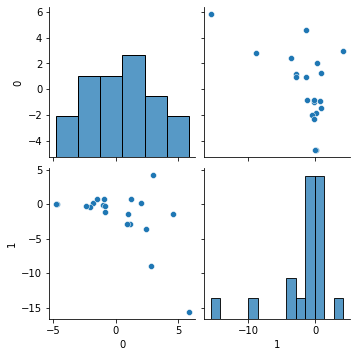

In [3]:
xdf = x_init[:, 0:2]
df = pd.DataFrame(xdf)
sns.pairplot(df)

In [4]:
truth_df = pd.read_csv('./fiducial_samples/noisy_funnel_100zD_sigma5_noncentred.csv', index_col=0)

truth_x = np.empty((200000, D + 1))
truth_x[:, 0] = truth_df["('posterior', 'theta')"]
for i in range(D):
    truth_x[:, i + 1] = truth_df["('posterior', 'z[{0}]', {1})".format(i, i)]
    
truth_x = truth_x[0::100, :]
print(np.shape(truth_x))
np.savetxt('./fiducial_samples/noise_funnel_100d_samples_sigma5_noncentred.txt', truth_x)

truth_df = pd.read_csv('./fiducial_samples/noisy_funnel_100zD_sigma5.csv', index_col=0)

truth_x_cen = np.empty((200000, D + 1))
truth_x_cen[:, 0] = truth_df["('posterior', 'theta')"]
for i in range(D):
    truth_x_cen[:, i + 1] = truth_df["('posterior', 'z[{0}]', {1})".format(i, i)]
    
truth_x_cen = truth_x_cen[0::100, :]
print(np.shape(truth_x))
np.savetxt('./fiducial_samples/noise_funnel_100d_samples_sigma5.txt', truth_x)

(2000, 101)
(2000, 101)


<AxesSubplot:ylabel='Density'>

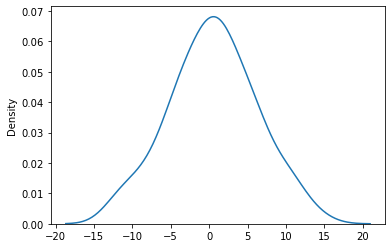

In [5]:
sns.kdeplot(data_sample)

<AxesSubplot:ylabel='Density'>

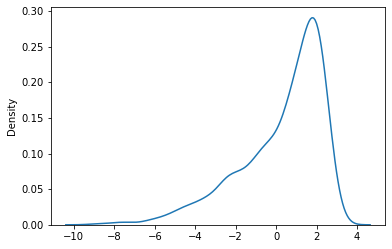

In [6]:
sns.kdeplot(truth_x[:, 0])

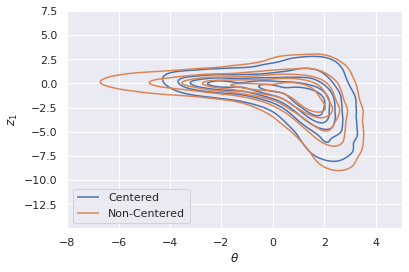

In [7]:
sns.set_theme()
plt.figure()
sns.kdeplot(x=truth_x_cen[:, 0], y=truth_x_cen[:, 1], label='Centered', levels=6)
sns.kdeplot(x=truth_x[:, 0], y=truth_x[:, 1], label='Non-Centered', levels=6)
plt.xlim(-8)
plt.xlabel(r'$\theta$')
plt.ylabel('$z_1$')
plt.legend(loc='lower left')
plt.savefig('./dla_figs/paper/funnel_sigma5_nuts_centering_comparison.png')

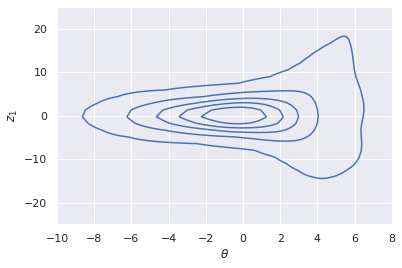

In [8]:
p_n01_init = jax.random.normal(jax.random.PRNGKey(0), shape=(2000, D + 1))
p_theta_init = p_n01_init[:, 0] * a
p_z_init = jax.vmap(lambda x1, x2: x1 * jnp.exp(x2 * b))(p_n01_init[:, 1:], p_theta_init)

sns.set_theme()
plt.figure()
sns.kdeplot(x=p_theta_init, y=p_z_init[:, 0], levels=6)
plt.xlabel(r'$\theta$')
plt.ylabel('$z_1$')
plt.xlim(-10, 8)
plt.ylim(-25, 25)
plt.savefig('./dla_figs/paper/neal_funnel_prior_plot.png')

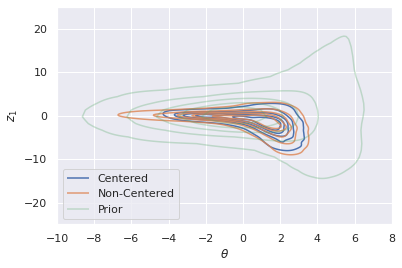

In [9]:
sns.set_theme()
plt.figure()
sns.kdeplot(x=truth_x_cen[:, 0], y=truth_x_cen[:, 1], label='Centered', alpha=1.0, levels=6)
sns.kdeplot(x=truth_x[:, 0], y=truth_x[:, 1], label='Non-Centered', alpha=0.8, levels=6)
sns.kdeplot(x=p_theta_init, y=p_z_init[:, 0], label='Prior', alpha=0.3, levels=6)
plt.xlim(-10, 8)
plt.ylim(-25, 25)
plt.xlabel(r'$\theta$')
plt.ylabel('$z_1$')
plt.legend(loc='lower left')
plt.savefig('./dla_figs/paper/funnel_100d_prior_plus_sigma5_nuts.png')

Below I have defined the key parameters that I think you will need to worry about. If you look at the actual code you'll see a lot more parameters. Some of these are from older versions of the algorithm, and some of these are only relevant for the NFO optimization algorithm. We'll tidy this up at some point, but this should be enough to get you going.

In [10]:
'''
General parameters
'''
log_like_args = (data_sample,)
log_prior_args = () 
vmap = True
parallel_backend = None
bounds = None
random_seed = seed

'''
SINF/SNF parameters
'''
#sinf parameters
reg_alpha = (0.98, 0.98)
NBfirstlayer = True
verbose = False
interp_nbin = 20
sgd_steps = 0
gamma = 0
knots_trainable = 20
optimize_directions = None
logp_cut = None
edge_bins = 0
Whiten = True
Whiten_with_weights = True
Whiten_reg = 0.98
iteration = 20
NERCOME = False
t_ess = 0.5
MSWD_max_iter = None
frac_validate = 0.2
snf_loss = 3
reg = 0.0
reg1 = 0.98
reg2 = 0.98

dla_step_size = 1.0
num_extra_dla_samples = 364
grad_norm_thresh = 0.5
max_dla_line_steps = 5
log_like_grad = log_like_grad
log_prior_grad = log_prior_grad
accelerate_dla = False
latent_dla = True
maxknot = False

max_dla_iter = 50
max_dla_burnin = 200

flow_type = 'SINF'
maf_layers = 10
maf_hidden = 5
maf_activation = torch.sigmoid
dropout_prob = 0.2
maf_epochs = 200

mala_step_size = 1e-3
num_mala = 1
tune_mala = 5

Now we can run our 10d Gaussian example.

In [11]:
trace = nfmc_jax.infer_dlmc(log_like_func=log_like, 
                             log_prior_func=log_prior,
                             init_samples=x_init,
                             log_like_args=log_like_args,
                             log_prior_args=log_prior_args,
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             #sinf parameters
                             reg_alpha=reg_alpha,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=Whiten,
                             Whiten_with_weights=Whiten_with_weights,
                             frac_validate=frac_validate,
                             snf_loss=snf_loss,
                             reg=reg,
                             reg1=reg1,
                             reg2=reg2,
                             t_ess=t_ess,
                             NERCOME=NERCOME,
                             dla_step_size=dla_step_size,
                             num_extra_dla_samples=num_extra_dla_samples,
                             grad_norm_thresh=grad_norm_thresh,
                             log_like_grad=log_like_grad,
                             log_prior_grad=log_prior_grad,
                             max_dla_line_steps=max_dla_line_steps,
                             accelerate_dla=accelerate_dla,
                             latent_dla=latent_dla,
                             max_dla_iter=max_dla_iter,
                             flow_type=flow_type,
                             maf_layers=maf_layers,
                             maf_hidden=maf_hidden,
                             maf_activation=maf_activation,
                             dropout_prob=dropout_prob,
                             maf_epochs=maf_epochs,
                             mala_step_size=mala_step_size,
                             num_mala=num_mala,
                             tune_mala=tune_mala,
                             maxknot=maxknot,
                             MSWD_max_iter=MSWD_max_iter,
                             Whiten_reg=Whiten_reg,
                             max_dla_burnin=max_dla_burnin)

Time for prior DLA = 4.719323146000008


/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:547: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1940.)
  Q, R = torch.qr(ATi)
/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:344: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = 

Current logZ estimate = 16949.826171875
Acceptance rate for MH adjustment: 0.25
Time for DLA MH adjustment = 1.441162896999998
Time for latent space DLA = 7.366313041999987
Current logZ estimate = 17594.87890625
Burnin stage 1, Fisher Divergence: 2170.759033203125
Burnin stage 1, abs(norm(dlogq)/norm(dlogp)) = 1.0830286741256714
Gradient norms are comparable - ending burnin ...
Stage 1, Sample Mean: -0.008335740305483341
Stage 1, Sample Variance: 2.654816150665283
Current logZ estimate = 3444.947265625
DLA stage 1, Latent Fisher Divergence: 12366.3876953125
Primary DLA stage 1, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.8042073845863342
Acceptance rate for MH adjustment: 0.5260416666666666
Time for DLA MH adjustment = 7.161713427999999
Time for latent space DLA = 13.930562242000008
Stage 2, Sample Mean: -0.002660379046574235
Stage 2, Sample Variance: 2.6856870651245117
Current logZ estimate = 3383.558837890625
DLA stage 2, Latent Fisher Divergence: 195.71160888671875
Primary DLA stage 2, abs[(Z(i

Acceptance rate for MH adjustment: 0.018229166666666668
Time for DLA MH adjustment = 1.466957146000027
Time for latent space DLA = 8.940702408999982
Stage 21, Sample Mean: 0.024973509833216667
Stage 21, Sample Variance: 3.2584285736083984
Current logZ estimate = 2920.1962890625
DLA stage 21, Latent Fisher Divergence: 290.6886901855469
Primary DLA stage 21, abs[(Z(i+1) - Z(i)) / Z(i)] = 67.1057357788086
Acceptance rate for MH adjustment: 0.028645833333333332
Time for DLA MH adjustment = 2.5024154600000657
Time for latent space DLA = 9.941360442000018
Stage 22, Sample Mean: 0.026270223781466484
Stage 22, Sample Variance: 3.3133862018585205
Current logZ estimate = 2916.750732421875
DLA stage 22, Latent Fisher Divergence: 340.2987365722656
Primary DLA stage 22, abs[(Z(i+1) - Z(i)) / Z(i)] = 55.85222244262695
Acceptance rate for MH adjustment: 0.0234375
Time for DLA MH adjustment = 2.07892949699999
Time for latent space DLA = 7.377148252999973
Stage 23, Sample Mean: 0.025010649114847183
Sta

Current logZ estimate = 2434.043212890625
DLA stage 41, Latent Fisher Divergence: 1707.89306640625
Primary DLA stage 41, abs[(Z(i+1) - Z(i)) / Z(i)] = 31.845104217529297
Acceptance rate for MH adjustment: 0.0078125
Time for DLA MH adjustment = 1.9251663039999585
Time for latent space DLA = 10.486641632999863
Stage 42, Sample Mean: 0.028730005025863647
Stage 42, Sample Variance: 4.889729022979736
Current logZ estimate = 2432.509765625
DLA stage 42, Latent Fisher Divergence: 1735.72998046875
Primary DLA stage 42, abs[(Z(i+1) - Z(i)) / Z(i)] = 32.88755798339844
Acceptance rate for MH adjustment: 0.0026041666666666665
Time for DLA MH adjustment = 1.9742752879999443
Time for latent space DLA = 5.9860602969999945
Stage 43, Sample Mean: 0.028829509392380714
Stage 43, Sample Variance: 4.994439601898193
Current logZ estimate = 2426.67431640625
DLA stage 43, Latent Fisher Divergence: 1834.6246337890625
Primary DLA stage 43, abs[(Z(i+1) - Z(i)) / Z(i)] = 27.593578338623047
Acceptance rate for MH 

100%|██████████| 6/6 [00:21<00:00,  3.58s/it]


Mean MALA acceptance rate = 0.0
Dual averaged step size = [[9.02785570e-04]
 [8.94501340e-04]
 [9.30033100e-04]
 [9.02196858e-04]
 [9.20941355e-04]
 [9.12789896e-04]
 [6.26459878e-05]
 [8.67495663e-04]
 [6.48723362e-05]
 [9.41448438e-04]
 [9.06515226e-04]
 [9.18376842e-04]
 [6.53857496e-05]
 [9.19287733e-04]
 [8.99849751e-04]
 [6.27860645e-05]
 [9.18130798e-04]
 [5.90682321e-05]
 [6.17307742e-05]
 [9.08894464e-04]
 [5.86237074e-05]
 [9.08412680e-04]
 [9.39931837e-04]
 [8.89747927e-04]
 [8.84412730e-04]
 [9.01836029e-04]
 [1.26195620e-04]
 [1.23947539e-04]
 [9.90323839e-04]
 [5.59766486e-04]
 [1.30271175e-04]
 [9.21293627e-04]
 [8.42612935e-04]
 [1.40769174e-04]
 [1.24012455e-04]
 [9.78455879e-04]
 [8.38167674e-04]
 [8.89781862e-04]
 [1.00086676e-03]
 [8.31848069e-04]
 [5.65102091e-04]
 [8.68662552e-04]
 [9.90067027e-04]
 [8.63493711e-04]
 [9.90533968e-04]
 [8.21553636e-04]
 [8.71377764e-04]
 [1.02140009e-03]
 [8.48045282e-04]
 [9.84561630e-04]
 [9.05742636e-04]
 [8.96159909e-04]
 [1.38

In [37]:
'''
f = open('./paper_experiments/funnel_100d_sigma5_trace.pkl', 'wb')
pickle.dump(trace, f)
f.close()
'''

The output from sampling is stored in the trace object. This is currently a collection of dictionaries containing a lot of output stats and samples for development/debugging purposes.

In [16]:
44.93142318725586# Check the dictionary keys.SINF
trace.keys()

dict_keys(['final_q_samples', 'final_qw_weights', 'log_evidence', 'mh_samples', 'dla_samples', 'mh_logp', 'mh_logq', 'mh_dlogp', 'mh_dlogq', 'dla_logZ', 'dla_q_models', 'dla_qw_models'])

In [17]:
# To inspect the sampling output, we can pull out the q_models.
q_models = trace['dla_q_models'][0]
q_models.keys()
#print(len(q_models.keys()))

dict_keys(['init_0', 'burnin_0', 'post_burnin_0', 'DLA_1', 'DLA_2', 'DLA_3', 'DLA_4', 'DLA_5', 'DLA_6', 'DLA_7', 'DLA_8', 'DLA_9', 'DLA_10', 'DLA_11', 'DLA_12', 'DLA_13', 'DLA_14', 'DLA_15', 'DLA_16', 'DLA_17', 'DLA_18', 'DLA_19', 'DLA_20', 'DLA_21', 'DLA_22', 'DLA_23', 'DLA_24', 'DLA_25', 'DLA_26', 'DLA_27', 'DLA_28', 'DLA_29', 'DLA_30', 'DLA_31', 'DLA_32', 'DLA_33', 'DLA_34', 'DLA_35', 'DLA_36', 'DLA_37', 'DLA_38', 'DLA_39', 'DLA_40', 'DLA_41', 'DLA_42', 'DLA_43', 'DLA_44', 'DLA_45', 'DLA_46', 'DLA_47', 'DLA_48', 'DLA_49', 'DLA_50', 'DLA_51'])

# Plotting

In [12]:
def sns_pairplot(q_samples, q_weights, truth_samples=None, q_label='q', 
                 truth_label='Truth', out_name=None, levels=10, legend_bbox=None, 
                 prior=False):
    
    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
        
    labels = []
    
    if truth_samples is not None:
        
        if prior:
            
            truth_samples = np.ones_like(q_samples) * 30
        
        truth_samples = np.asarray(truth_samples)
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    
        for i in range(len(q_samples)):
            labels.append(q_label)
        for i in range(len(truth_samples)):
            labels.append(truth_label)
    
    else:

        x_samples = q_samples
        weights = q_weights
        
        for i in range(len(q_samples)):
            labels.append(q_label)
    
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        if i == 0:
            d[r'$\theta$'] = x_samples[:, i]
        else:
            d[f'$z_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    print(df)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels, bw=0.5)
    g.map_lower(sns.kdeplot, weights=weights, common_norm=False, levels=levels, bw=0.5)
    g.map_upper(sns.kdeplot, weights=weights, common_norm=False, levels=levels, bw=0.5)
    g.axes[1, 0].set_ylim(-25, 25)
    g.axes[1, 0].set_xlim(-12, 10)
    g.axes[0, 1].set_xlim(-25, 25)
    g.axes[0, 1].set_ylim(-12, 10)
    if legend_bbox is not None:
        g.add_legend(bbox_to_anchor=legend_bbox)
    if out_name is not None:
        g.savefig(out_name)

     labels   $\theta$       $z_1$
0      DLMC   8.800482 -158.385437
1      DLMC  -2.788373    0.154888
2      DLMC   1.235584   -0.267488
3      DLMC  -3.779295    0.051061
4      DLMC   0.127440    0.750431
...     ...        ...         ...
3995   NUTS  30.000000   30.000000
3996   NUTS  30.000000   30.000000
3997   NUTS  30.000000   30.000000
3998   NUTS  30.000000   30.000000
3999   NUTS  30.000000   30.000000

[4000 rows x 3 columns]


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarni

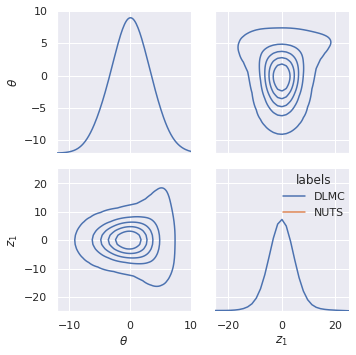

In [19]:
p_n01_init = jax.random.normal(jax.random.PRNGKey(0), shape=(2000, D + 1))
p_theta_init = p_n01_init[:, 0] * a
p_z_init = jax.vmap(lambda x1, x2: x1 * jnp.exp(x2 * b))(p_n01_init[:, 1:], p_theta_init)
p_init = np.concatenate([p_theta_init.reshape(len(p_theta_init), 1), p_z_init], axis=1)

sns_pairplot(p_init[:, 0:2], np.ones(len(p_init)), p_init[:, 0:2], q_label='DLMC', truth_label='NUTS', 
             levels=6, legend_bbox=(0.84, 0.45), prior=True,
             out_name='./dla_figs/paper/funnel_100d_prior.png')

()
<theta> = 0.14170487225055695
Var(theta) = 5.878365993499756


<Figure size 432x288 with 0 Axes>

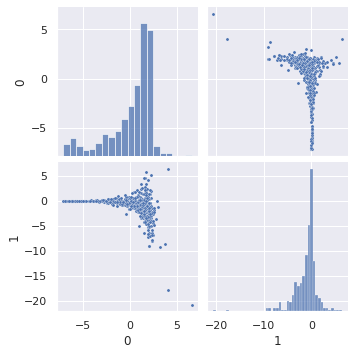

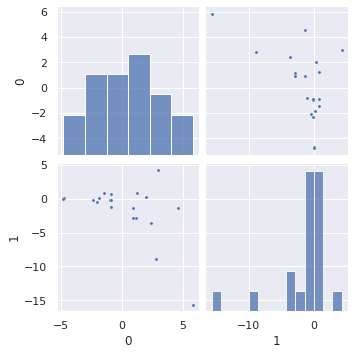

In [13]:
#mh_samples = trace['final_q_samples'][0]
mh_samples = trace['mh_samples'][0]
print(np.shape(mh_samples))
x = mh_samples['DLA_50'][:, 0:2]
plt.figure()
sns.pairplot(pd.DataFrame(x),
             plot_kws={'s': 10})
sns.pairplot(pd.DataFrame(x_init[:,0:2]), plot_kws={'s': 10})
#plt.savefig('./dla_figs/dla_samples_DLA_15_nowhiten.png')

print(f'<theta> = {np.mean(x[:, 0])}')
print(f'Var(theta) = {np.var(x[:, 0])}')

#np.savetxt('./dla_figs/dla_samples_DLA_15_nowhiten.txt', mh_samples['DLA_15'])

<theta> = 0.26820759856596044
Var(theta) = 4.364824213814596


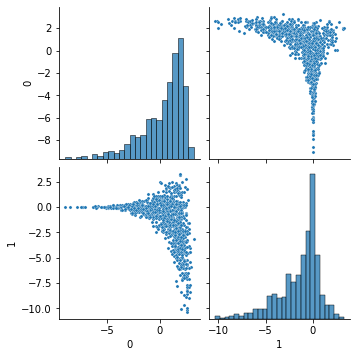

In [31]:
truth_choice = np.random.choice(np.arange(len(truth_x)), size=len(mh_samples['DLA_1']), replace=False)

sns.pairplot(pd.DataFrame(truth_x[:, 0:2][truth_choice]), plot_kws={'s': 10})

print(f'<theta> = {np.mean(truth_x[:, 0])}')
print(f'Var(theta) = {np.var(truth_x[:, 0])}')

In [46]:
np.savetxt('./fiducial_samples/funnel_100d_sigma5_plot_selection.txt')

TypeError: _savetxt_dispatcher() missing 1 required positional argument: 'X'

<ipython-input-29-e533fb7555c3>:15: RuntimeWarning: invalid value encountered in true_divide
  iw /= np.sum(iw)


     labels  $\theta$     $z_1$
0         q  1.879358 -0.488152
1         q  0.955598 -1.281761
2         q  2.410310 -0.645205
3         q -2.110099 -1.008760
4         q -0.010560 -0.789812
...     ...       ...       ...
3995  Truth  1.816429 -0.650998
3996  Truth -2.591551 -0.616467
3997  Truth  1.916494 -5.267941
3998  Truth  1.578636 -4.327265
3999  Truth  2.619161 -7.687760

[4000 rows x 3 columns]


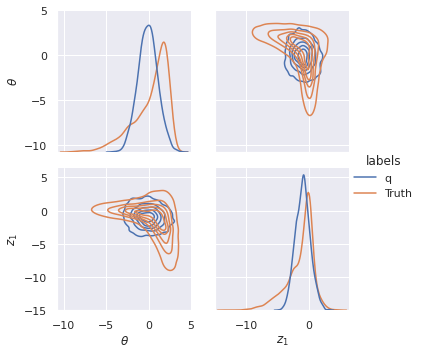

In [29]:
q_string = 'DLA_51'

# There were 10 temperature levels. q10_w corresponds to the q fit at beta=1 i.e. the target.
qi = q_models[q_string]
q_samples = qi.sample(2000)
logq = qi.logq(q_samples)
q_samples, logq = q_samples.numpy(), logq.numpy()
iw = jax.vmap(lambda x: log_like(x))(q_samples)
logp = jax.vmap(lambda x: log_like(x))(q_samples)
logw = logp - logq
#logw = np.clip(logw, a_min=-np.inf, a_max=logsumexp(logw) - 0.1 * np.log(len(logw)))
#logw, _ = az.psislw(np.copy(np.asarray(logw)))
#logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)

sns_pairplot(q_samples[:, 0:2], np.ones(len(q_samples)), 
             truth_samples=truth_x[:, 0:2], levels=6,
             out_name=f'./dla_figs/q_nercome_{q_string}.png')

     labels     $x_0$     $x_1$
0         q  1.126003 -0.363005
1         q -0.564510  0.148403
2         q  0.108752 -1.346305
3         q -0.442728 -0.025617
4         q  0.629480 -1.744686
...     ...       ...       ...
3995      T -0.082282  0.505557
3996      T -2.351558  0.476536
3997      T -0.556014 -0.488731
3998      T  2.313240 -1.424104
3999      T  1.935976  1.002505

[4000 rows x 3 columns]


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seabor

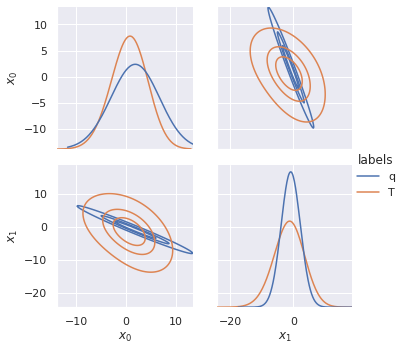

In [20]:
sns_pairplot(q_samples[:, 0:2], iw, truth_samples=truth_x[:, 0:2], levels=4)

    labels      $x_0$     $x_1$
0        q   2.434003 -4.642616
1        q -12.083573  0.000795
2        q   0.844314  0.436975
3        q   2.039425 -3.906636
4        q   1.058957 -2.563526
..     ...        ...       ...
403      T   1.385499 -0.128557
404      T  -1.818305  0.112370
405      T   0.707915 -1.366916
406      T  -2.629949  0.107314
407      T  -4.289157 -0.028206

[408 rows x 3 columns]


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/

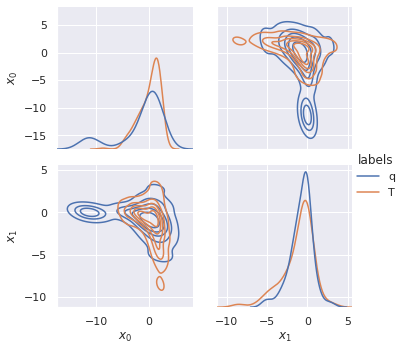

In [40]:
#llk = jax.vmap(lambda x: mh_samples[''])

'''
key = 'DLA_20'
#samples = mh_samples[key]
llk = jax.vmap(lambda x: log_like(x))(samples)
lpr = jax.vmap(lambda x: log_prior(x))(samples)

q = q_models['DLA_21']
logq = q.logq(torch.tensor(np.asarray(samples), dtype=torch.float32))
logq = logq.detach().numpy()
#logq[logq < lpr] = lpr[logq < lpr]

logw = llk + lpr - logq
#logw = jnp.clip(logw, a_min=-jnp.inf, a_max=logsumexp(logw) - 0.5 * jnp.log(len(logw)))
logw, _ = az.psislw(np.copy(np.asarray(logw)))
logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)
'''


sns_pairplot(x, np.ones(len(x)),
             truth_samples=truth_x[:, 0:2][truth_choice], levels=6)
             #out_name=f'./dla_figs/paper/funnel_100d_sigma5_particle_density_{key}.png')

     labels  $\theta$      $z_1$
0      DLMC  6.531523 -20.106182
1      DLMC  1.622671  -0.011055
2      DLMC  2.046092  -2.493630
3      DLMC  3.581688  -8.230118
4      DLMC  0.863552   1.473951
...     ...       ...        ...
2379   NUTS  1.816429  -0.650998
2380   NUTS -2.591551  -0.616467
2381   NUTS  1.916494  -5.267941
2382   NUTS  1.578636  -4.327265
2383   NUTS  2.619161  -7.687760

[2384 rows x 3 columns]


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/

<theta> = 0.3009830415248871
Var(theta) = 3.2458674907684326


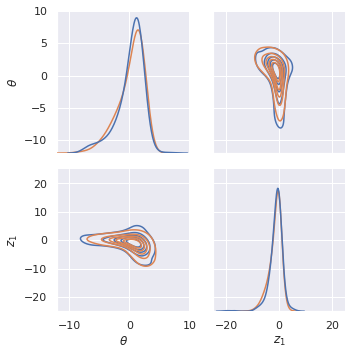

In [21]:
dla_key = 'DLA_45'
#idx = np.where(mh_samples[dla_key][:, 1] > -15)[0]
sns_pairplot(mh_samples[dla_key][:, 0:2], 
             np.ones(len(mh_samples['DLA_20'][:, 0:2])),
             truth_samples=truth_x[:, 0:2], levels=6, 
             q_label='DLMC', truth_label='NUTS')


theta = mh_samples['DLA_40'][:, 0]
print(f'<theta> = {np.mean(theta)}')
print(f'Var(theta) = {np.var(theta)}')

    labels     $x_0$     $x_1$
0        q -9.106716 -0.003999
1        q -3.252151 -0.028418
2        q -1.590654 -0.242584
3        q -2.267929  0.022262
4        q  0.501325 -0.519793
..     ...       ...       ...
403      T  2.094792 -0.554090
404      T -1.605183 -0.019230
405      T  1.083862 -3.529792
406      T -0.528012  0.516568
407      T -4.347571 -0.077237

[408 rows x 3 columns]


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/

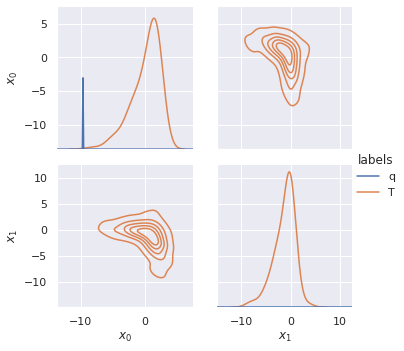

In [32]:
samples = mh_samples['DLA_60']

llk = jax.vmap(lambda x: log_like(x))(samples)
lpr = jax.vmap(lambda x: log_prior(x))(samples)

q = q_models['DLA_61']
logq = q.logq(torch.tensor(np.asarray(samples), dtype=torch.float32))
logq = logq.detach().numpy()
#logq[logq < lpr] = lpr[logq < lpr]

logw = llk + lpr - logq
#logw = jnp.clip(logw, a_min=-jnp.inf, a_max=logsumexp(logw) - 0.5 * jnp.log(len(logw)))
#logw, _ = az.psislw(np.copy(np.asarray(logw)))
logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)

sns_pairplot(mh_samples['DLA_60'][:, 0:2], iw,
             truth_samples=truth_x[:, 0:2][truth_choice], levels=6)

     labels      $x_0$     $x_1$
0         q   0.041436 -2.219766
1         q   1.690544 -3.879961
2         q -10.173237 -0.001502
3         q   0.535329  0.196512
4         q   0.317201 -1.585895
...     ...        ...       ...
2199      T  -2.942711 -0.921737
2200      T  -3.332084 -0.784060
2201      T  -2.041063 -2.456563
2202      T  -0.211027  1.604710
2203      T  -0.501648  0.575439

[2204 rows x 3 columns]


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/

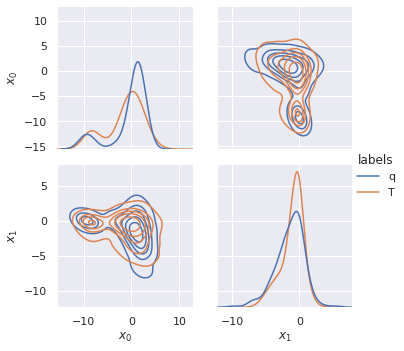

In [27]:
q_string = 'DLA_71'
qi = q_models[q_string]
q_samples = qi.sample(2000)
q_samples = q_samples.detach().numpy()

sns_pairplot(mh_samples['DLA_70'][:, 0:2], np.ones(len(mh_samples['DLA_20'][:, 0:2])),
             truth_samples=q_samples[:, 0:2], levels=6)

     labels     $x_0$      $x_1$
0         q -4.038528  -0.031618
1         q  7.035622  36.902431
2         q -5.307450   0.082544
3         q  0.091827  -0.976080
4         q  1.455737   1.753104
...     ...       ...        ...
2399      T -0.082282   0.505557
2400      T -2.351558   0.476536
2401      T -0.556014  -0.488731
2402      T  2.313240  -1.424104
2403      T  1.935976   1.002505

[2404 rows x 3 columns]


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/

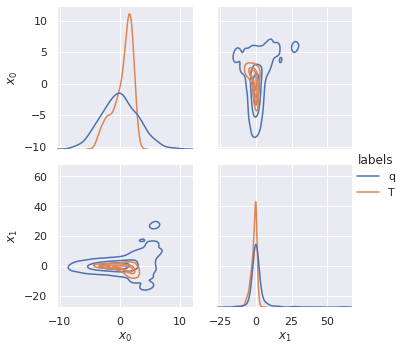

In [37]:
sns_pairplot(x_init[:, 0:2], np.ones(len(mh_samples['DLA_1'][:, 0:2])),
             truth_samples=truth_x[:, 0:2], levels=4)

# Trial culling methods ...

In [12]:
samples = mh_samples['burnin_0']
q_string = 'post_burnin_0'

# There were 10 temperature levels. q10_w corresponds to the q fit at beta=1 i.e. the target.
q = q_models[q_string]

llk = jax.vmap(lambda x: log_like(x))(samples)
lpr = jax.vmap(lambda x: log_prior(x))(samples)

logp = llk + lpr
logq = q.logq(torch.tensor(np.asarray(samples), dtype=torch.float32))
logq = jnp.asarray(logq.detach().numpy())

NameError: name 'mh_samples' is not defined

     labels     $x_0$     $x_1$
0         q  0.830124  3.231688
1         q -0.949933 -0.698442
2         q -4.838340 -0.202397
3         q  0.973297  2.553145
4         q  1.677231 -1.517583
...     ...       ...       ...
2197      T  0.985898 -2.438323
2198      T  0.671550 -3.739521
2199      T  0.474490 -2.201923
2200      T  0.834931 -2.900510
2201      T  0.918914 -3.999274

[2202 rows x 3 columns]


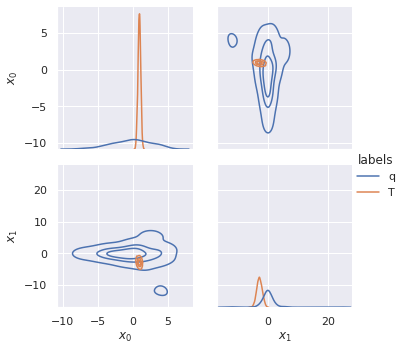

In [133]:
sns_pairplot(samples[:, 0:2], np.ones(len(samples)), truth_x[:, 0:2], levels=4)

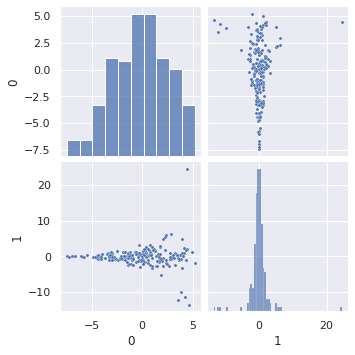

In [134]:
sns.pairplot(pd.DataFrame(samples[:, 0:2]), plot_kws={'s': 10})

In [135]:
def evaluate_dla_beta(samples, log_like, log_prior, logq, t_ess):
    """Calculate the beta for accelerating convergence."""
    low_beta = 0.0
    up_beta = 2.0
    rN = int(len(samples) * t_ess)

    while up_beta - low_beta > 1e-6:
        new_beta = (low_beta + up_beta) / 2.0

        log_temp_weights_un = log_like + log_prior - logq
        ESS = int(jnp.exp(
            2 * logsumexp(new_beta * log_temp_weights_un) - logsumexp(2.0 * new_beta * log_temp_weights_un)))

        #log_temp_weights_un = new_beta * log_like + log_prior - logq
        #log_temp_weights = log_temp_weights_un - logsumexp(log_temp_weights_un)
        #ESS = int(jnp.exp(-logsumexp(log_temp_weights * 2)))
        if ESS == rN:
            break
        elif ESS < rN:
            up_beta = new_beta
        else:
            low_beta = new_beta
    if new_beta >= 1:
        new_beta = 1
    dla_beta = new_beta
    dla_log_weights = dla_beta * (log_like + log_prior - logq)
    #dla_log_weights = dla_beta * log_like + log_prior - logq
    dla_log_weights -= logsumexp(dla_log_weights)

    print(f'DLA acceleration beta = {dla_beta}')
    
    return dla_beta, dla_log_weights

In [136]:
dla_beta, dla_logw = evaluate_dla_beta(samples, llk, lpr, logq, 0.5)

DLA acceleration beta = 0.00013446807861328125


In [137]:
def dla_resample(dla_log_weights, samples, likelihood_logp, prior_logp, logq):
    """Re-sample based on weighted qw weights."""
    dla_weights = jnp.exp(dla_log_weights)

    u = (jnp.arange(len(samples)) + jax.random.uniform(jax.random.PRNGKey(0), minval=0, maxval=1,
                                                       shape=(len(samples),))) / len(samples)
    bins = jnp.cumsum(dla_weights)
    resampling_indexes = jnp.digitize(u, bins)

    samples = samples[resampling_indexes]
    likelihood_logp = likelihood_logp[resampling_indexes]
    prior_logp = prior_logp[resampling_indexes]
    logq = logq[resampling_indexes]
    
    return samples, likelihood_logp, prior_logp, logq

In [138]:
samples, llk, lpr, logq = dla_resample(dla_logw, samples, llk, lpr, logq)

     labels     $x_0$     $x_1$
0         q -0.949933 -0.698442
1         q -4.838340 -0.202397
2         q  0.973297  2.553145
3         q  1.677231 -1.517583
4         q  1.677231 -1.517583
...     ...       ...       ...
2197      T  0.985898 -2.438323
2198      T  0.671550 -3.739521
2199      T  0.474490 -2.201923
2200      T  0.834931 -2.900510
2201      T  0.918914 -3.999274

[2202 rows x 3 columns]


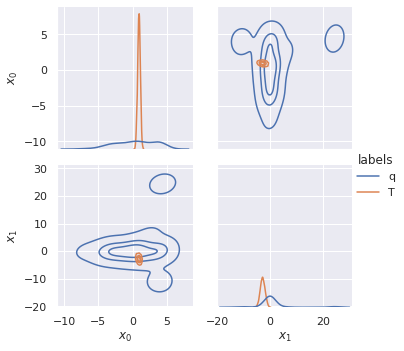

In [139]:
sns_pairplot(samples[:, 0:2], np.ones(len(samples)),
             truth_samples=truth_x[:, 0:2], levels=4)

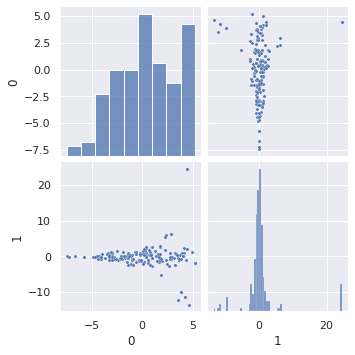

In [140]:
sns.pairplot(pd.DataFrame(samples[:, 0:2]), plot_kws={'s': 10})

# Sanity check SINF edits ...

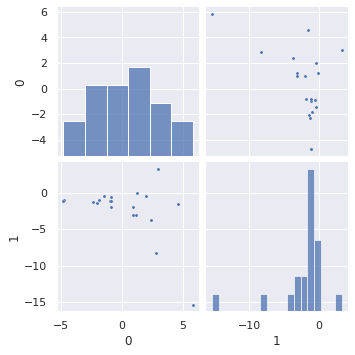

In [20]:
prior_dla = np.loadtxt('/home/richard/nfmc_jax_tests/fiducial_samples/prior_dla_samples.txt')
sns.pairplot(pd.DataFrame(prior_dla[:, 0:2]), plot_kws={'s': 10})

    labels     $x_0$      $x_1$
0        q -2.832651  -1.848245
1        q -1.641508  -2.017949
2        q  6.236219  23.832371
3        q  2.347805  -1.107939
4        q  2.080040  -0.515664
..     ...       ...        ...
803      T  1.681235  -0.662764
804      T  3.144183  -4.050927
805      T -1.317157  -0.224044
806      T -0.272364  -0.325441
807      T  4.242241   4.582406

[808 rows x 3 columns]


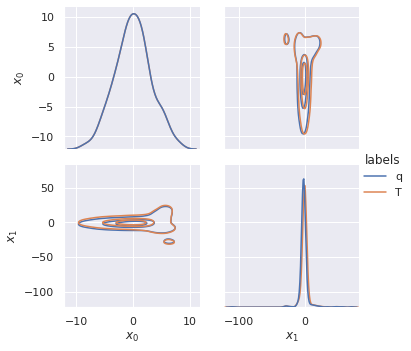

In [15]:
sns_pairplot(prior_dla[:, 0:2], np.ones(len(prior_dla)), truth_samples=x_init[:, 0:2], levels=4)

# Check MH

In [82]:
def mh_update_check(dla_samples, q_model):
    '''
    This function should sanity check the MH acceptance procedure ...
    '''
    
    llk_current = jax.vmap(lambda x: log_like(x))(dla_samples)
    lpr_current = jax.vmap(lambda x: log_prior(x))(dla_samples)
    logp_current = llk_current + lpr_current
    logq_current = q_model.logq(torch.tensor(np.asarray(dla_samples), dtype=torch.float32))
    logq_current = jnp.asarray(logq_current.detach().numpy())
    
    prop_samples = q_model.sample(len(dla_samples))
    logq_prop = q_model.logq(prop_samples)
    logq_prop = jnp.asarray(logq_prop.detach().numpy())
    prop_samples = jnp.asarray(prop_samples.detach().numpy())
    
    llk_prop = jax.vmap(lambda x: log_like(x))(prop_samples)
    lpr_prop = jax.vmap(lambda x: log_prior(x))(prop_samples)
    logp_prop = llk_prop + lpr_prop
    
    log_alpha = logp_prop + logq_current - logp_current - logq_prop
    alpha = jnp.clip(jnp.exp(log_alpha), a_min=0, a_max=1)
    
    '''
    print(f'log_alpha = {log_alpha}')
    print(f'alpha = {alpha}')
    print(f'logp_current = {logp_current}')
    print(f'logq_current = {logq_current}')
    print(f'logp_prop = {logp_prop}')
    print(f'logq_prop = {logq_prop}')
    '''
    low_x0 = jnp.where(dla_samples[:, 0] < -1.)
    #print(f'log_alpha = {log_alpha[low_x0]}')
    #print(f'alpha = {alpha[low_x0]}')
    #print(f'logp_current = {logp_current[low_x0]}')
    #print(f'logq_current = {logq_current[low_x0]}')
    #print(f'logp_prop = {logp_prop[low_x0]}')
    #print(f'logq_prop = {logq_prop[low_x0]}')
    #print(f'prop_samples = {prop_samples[low_x0, 0]}')
    print(f'logL current = {llk_current[low_x0]}')
    print(f'logpi current = {lpr_current[low_x0]}')
    print(f'prop logL = {llk_prop[low_x0]}')
    print(f'prop logpi = {lpr_prop[low_x0]}')
    
    return prop_samples[low_x0]

In [83]:
dla_samples = trace['dla_samples'][0]
x = dla_samples['DLA_69']
q = q_models['DLA_70']

prop = mh_update_check(x, q)

logL current = [-188.72256 -206.24358]
logpi current = [-115.589134  -91.5259  ]
prop logL = [-139.1373  -147.40573]
prop logpi = [-188.43283 -185.82013]


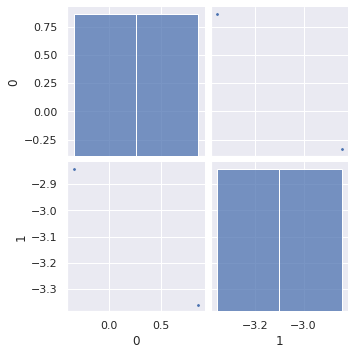

In [81]:
sns.pairplot(pd.DataFrame(np.asarray(prop[:, 0:2])), plot_kws={'s': 10})